In [82]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
print("OK ✅", pd.__version__, sklearn.__version__)

OK ✅ 3.0.0 1.8.0


# Laboratorio 1 — AlpesHearth

## 1. Carga de datos

In [83]:
TRAIN_PATH = "Datos Lab 1.csv"
TEST_PATH  = "Datos Test Lab 1.csv"       
TARGET_COL = "CVD Risk Score"    

df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH, sep=";")

data_copy = df.copy()
data_test_copy = df_test.copy()


## 2. Exploración y perfilamiento

### Unicidad 
los datos, revisaremos que no existan datos duplicados, que harian que nuestro modelo empiece a tomar tendencias que no deberia, todos estos registros duplicados los limpiearemos.

In [84]:
data_copy.duplicated(keep = False).sum()
# Detalle de los registros
dup_table = (
    data_copy[data_copy['Patient ID'].duplicated(keep=False)]
    .copy()
    .assign(repeticiones=data_copy.groupby('Patient ID')['Patient ID'].transform('size'))
    .sort_values(['repeticiones', 'Patient ID'], ascending=[False, True])
)
# Mostrar tabla
dup_table

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level,repeticiones
17,AhYt1346,09-28-2020,M,41.0,71.300,1.730,23.800,107.9,139/61,253.0,...,Y,173.000,NaN,139.0,NaN,Hypertension Stage 1,146.0,16.770,HIGH,3
1227,AhYt1346,09-28-2020,M,41.0,71.300,1.730,23.800,107.9,139/61,253.0,...,Y,173.000,NaN,139.0,NaN,Hypertension Stage 1,146.0,-13.090,HIGH,3
1584,AhYt1346,09-28-2020,M,41.0,71.300,1.730,23.800,107.9,139/61,253.0,...,Y,173.000,NaN,139.0,NaN,Hypertension Stage 1,146.0,16.770,HIGH,3
130,BQvQ6431,09/11/2020,M,33.0,118.300,1.690,41.400,72.1,116/93,171.0,...,N,210.554,0.427,116.0,93.0,Hypertension Stage 2,97.0,17.500,LOW,3
1469,BQvQ6431,09/11/2020,M,33.0,118.300,1.690,41.400,72.1,116/93,171.0,...,N,210.554,0.427,116.0,93.0,Hypertension Stage 2,97.0,29.833,LOW,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,yvsn3005,28 Oct 20,F,60.0,54.300,1.810,16.600,99.1,133/65,187.0,...,N,181.000,0.548,133.0,65.0,Hypertension Stage 1,79.0,15.710,INTERMEDIARY,2
95,zcgB3048,12/06/2020,M,38.0,60.436,1.506,20.269,79.7,168/63,119.0,...,N,150.616,0.529,168.0,63.0,Hypertension Stage 2,43.0,14.834,HIGH,2
375,zcgB3048,12/06/2020,M,38.0,60.436,1.506,20.269,79.7,168/63,119.0,...,N,150.616,0.529,168.0,63.0,Hypertension Stage 2,43.0,14.834,HIGH,2
799,zxhX5525,"November 13, 2021",M,26.0,58.953,1.688,25.286,NaN,110/114,258.0,...,Y,168.763,0.455,110.0,114.0,Hypertension Stage 2,170.0,15.717,HIGH,2


In [85]:
# Convertir la columna fecha a tipo datetime
data_copy['Date of Service'] = pd.to_datetime(
    data_copy['Date of Service'],
    format='mixed',
    dayfirst=False,
    errors='coerce'
)

# Ordenar por ID y Date of Service
data_copy = data_copy.sort_values(['Patient ID', 'Date of Service'], ascending=[True, False])

# Eliminar duplicados, quedándose con la más reciente por ID
data_copy = data_copy.drop_duplicates(subset='Patient ID', keep='first')

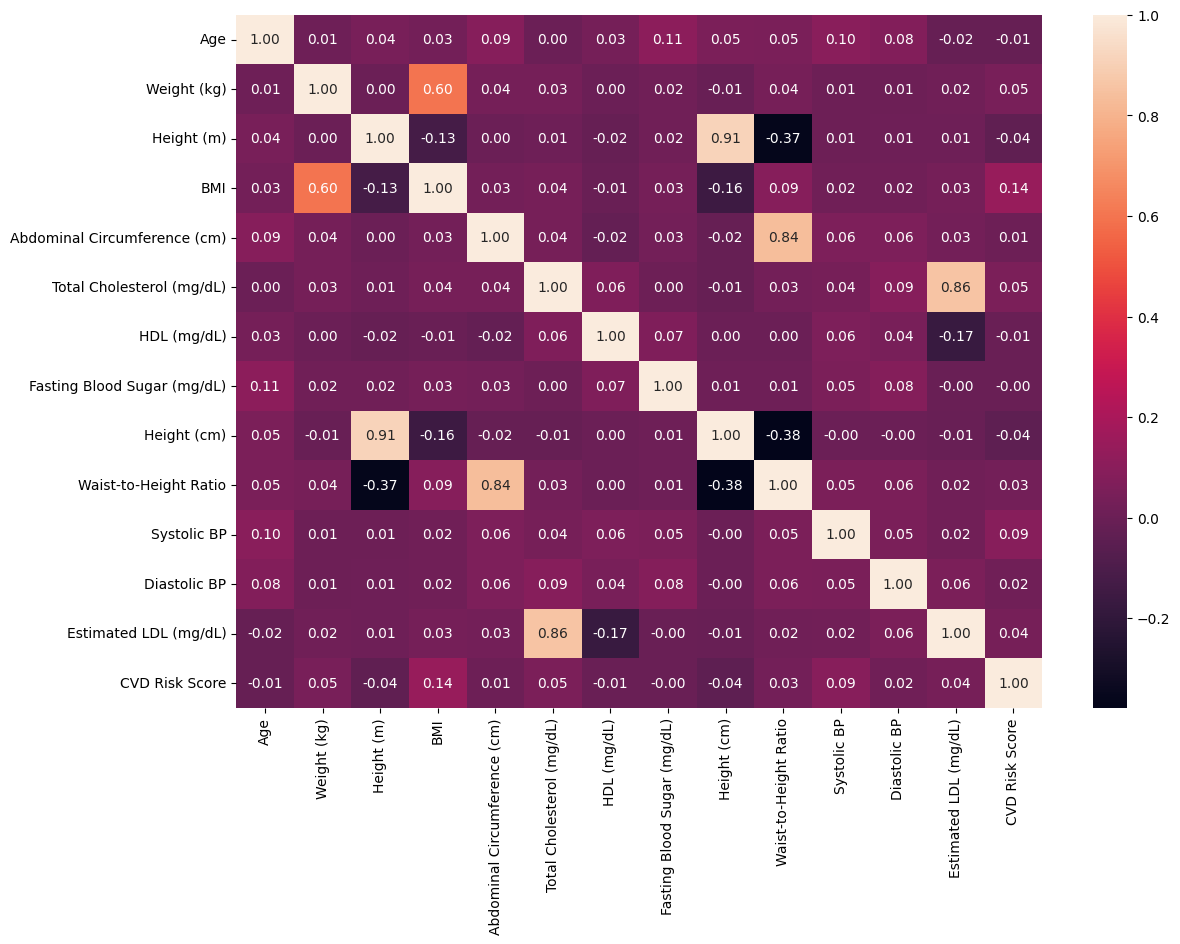

In [86]:
plt.figure(figsize=(13, 9))  # ancho x alto en pulgadas
sns.heatmap(data_copy.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()


Vemos que aun tenemos muchos valores en NULL, esto nos afecta porque nuestro modelo no podra estar bien ajustado y tendremos que corregir estos datos. 

In [87]:



data_copy['Height (cm)'] = data_copy['Height (cm)'].fillna(data_copy['Height (m)'] * 100)
data_copy = data_copy[~(data_copy['Height (cm)'].isna() & data_copy['Height (m)'].isna())]

# RECONSTRUIR BMI = weight_kg / (height_m^2)
data_copy['height_m_temp'] = data_copy['Height (cm)'] / 100

data_copy['BMI'] = data_copy['BMI'].fillna(data_copy['Weight (kg)'] / (data_copy['height_m_temp'] ** 2))

data_copy = data_copy[~(data_copy['BMI'].isna())]

data_copy['Waist-to-Height Ratio'] = data_copy['Waist-to-Height Ratio'].fillna(
    data_copy['Abdominal Circumference (cm)'] / data_copy['Height (cm)']
)

data_copy = data_copy[~data_copy['Waist-to-Height Ratio'].isna()]

data_copy = data_copy.drop(columns=[ 'height_m_temp'], errors='ignore')

def split_bp(value):
    if isinstance(value, str) and "/" in value:
        sys, dia = value.split("/")
        return float(sys), float(dia)
    return (None, None)

data_copy[['BP_sys', 'BP_dia']] = data_copy['Blood Pressure (mmHg)'].apply(
    lambda x: pd.Series(split_bp(x))
)

data_copy['Systolic BP'] = data_copy['Systolic BP'].fillna(data_copy['BP_sys'])
data_copy['Diastolic BP'] = data_copy['Diastolic BP'].fillna(data_copy['BP_dia'])

data_copy = data_copy.drop(columns=['BP_sys', 'BP_dia'])

data_test_copy[['BP_sys', 'BP_dia']] = data_test_copy['Blood Pressure (mmHg)'].apply(
    lambda x: pd.Series(split_bp(x))
)

data_test_copy['Systolic BP'] = data_test_copy['Systolic BP'].fillna(data_test_copy['BP_sys'])
data_test_copy['Diastolic BP'] = data_test_copy['Diastolic BP'].fillna(data_test_copy['BP_dia'])

data_test_copy = data_test_copy.drop(columns=['BP_sys', 'BP_dia'])

data_copy['Weight (kg)'] = data_copy['Weight (kg)'].fillna(
    data_copy['BMI'] * (data_copy['Height (cm)'] / 100) ** 2
)
data_copy['Weight (kg)'] = data_copy['Weight (kg)'].fillna(
    data_copy['Weight (kg)'].median()
)

data_copy['HDL (mg/dL)'] = data_copy['HDL (mg/dL)'].fillna(
    data_copy['HDL (mg/dL)'].median()
)

data_copy['Age'] = data_copy['Age'].fillna(data_copy['Age'].median())

data_copy['Total Cholesterol (mg/dL)'] = data_copy['Total Cholesterol (mg/dL)'].fillna(
    data_copy['Total Cholesterol (mg/dL)'].median()
)

data_copy['Abdominal Circumference (cm)'] = data_copy['Abdominal Circumference (cm)'].fillna(
    data_copy['Waist-to-Height Ratio'] * data_copy['Height (cm)']
)
data_copy['Abdominal Circumference (cm)'] = data_copy['Abdominal Circumference (cm)'].fillna(
    data_copy['Abdominal Circumference (cm)'].median()
)

data_copy['Fasting Blood Sugar (mg/dL)'] = data_copy['Fasting Blood Sugar (mg/dL)'].fillna(
    data_copy['Fasting Blood Sugar (mg/dL)'].median()
)

data_copy['Estimated LDL (mg/dL)'] = data_copy['Estimated LDL (mg/dL)'].fillna(
    data_copy['Estimated LDL (mg/dL)'].median()
)


((data_copy.isnull().sum()/data_copy.shape[0])).sort_values(ascending=False)


Height (m)                      0.033552
CVD Risk Score                  0.020423
Sex                             0.000000
Patient ID                      0.000000
Age                             0.000000
Weight (kg)                     0.000000
BMI                             0.000000
Date of Service                 0.000000
Abdominal Circumference (cm)    0.000000
Blood Pressure (mmHg)           0.000000
HDL (mg/dL)                     0.000000
Total Cholesterol (mg/dL)       0.000000
Smoking Status                  0.000000
Diabetes Status                 0.000000
Physical Activity Level         0.000000
Fasting Blood Sugar (mg/dL)     0.000000
Family History of CVD           0.000000
Height (cm)                     0.000000
Systolic BP                     0.000000
Waist-to-Height Ratio           0.000000
Diastolic BP                    0.000000
Blood Pressure Category         0.000000
Estimated LDL (mg/dL)           0.000000
CVD Risk Level                  0.000000
dtype: float64

### DROP de columnas de datos no necesarios para el modelo

Para realizar nuestro modelo, necesitamos solamente datos que nos den informacion sobre la salud del paciente, por este eliminamos 
- Patient ID 
- Date of Service

Y tambien, eliminamos nuestras variables objetivos, que determinando una podemos llegar a la otra, pero esta directamente relacionadas.
- "CVD Risk Level"
- "CVD Risk Score"

Y tambien drop de colomnas que tengas demasida relacion y no nos aportan informacion adicional
- Height (m)

In [95]:
# Información general
data_copy.shape

# Conteo de valores nulos
data_copy.isna().sum().sort_values(ascending=False)

cols_to_drop = [
    "Patient ID",
    "Date of Service",
    "CVD Risk Level",
    "CVD Risk Score",
    "Height (m)"
]

data_copy = data_copy.drop(columns=cols_to_drop, errors="ignore")
data_test_copy = data_test_copy.drop(columns=cols_to_drop, errors="ignore")


Sex
F    693
M    678
Name: count, dtype: int64
 
Smoking Status
Y    708
N    663
Name: count, dtype: int64
Diabetes Status
Y    696
N    675
Name: count, dtype: int64
Physical Activity Level
High        471
Moderate    458
Low         442
Name: count, dtype: int64
Family History of CVD
N    698
Y    673
Name: count, dtype: int64
Blood Pressure Category
Hypertension Stage 2    564
Hypertension Stage 1    449
Normal                  268
Elevated                 90
Name: count, dtype: int64


### Consistencia
Miramos que todos los datos que tenemos, vengan con el formato que se nos indica

Primero vemos los valores que no son numericos

In [99]:
print(data_copy["Sex"].value_counts(dropna=False))
print(" ")
print(data_copy["Smoking Status"].value_counts(dropna=False))
print(" ")
print(data_copy["Diabetes Status"].value_counts(dropna=False))
print(" ")
print(data_copy["Physical Activity Level"].value_counts(dropna=False))
print(" ")
print(data_copy["Family History of CVD"].value_counts(dropna=False))
print(" ")
print(data_copy["Blood Pressure Category"].value_counts(dropna=False))

Sex
F    693
M    678
Name: count, dtype: int64
 
Smoking Status
Y    708
N    663
Name: count, dtype: int64
 
Diabetes Status
Y    696
N    675
Name: count, dtype: int64
 
Physical Activity Level
High        471
Moderate    458
Low         442
Name: count, dtype: int64
 
Family History of CVD
N    698
Y    673
Name: count, dtype: int64
 
Blood Pressure Category
Hypertension Stage 2    564
Hypertension Stage 1    449
Normal                  268
Elevated                 90
Name: count, dtype: int64


Ahora miramos si los datos numericos

In [100]:
for col in data_copy.select_dtypes(include=["int64", "float64"]).columns:
    not_numeric = pd.to_numeric(data_copy[col], errors="coerce").isna()
    invalid_count = not_numeric.sum()
    print(f"{col}: valores NO numéricos = {invalid_count}")

Age: valores NO numéricos = 0
Weight (kg): valores NO numéricos = 0
BMI: valores NO numéricos = 0
Abdominal Circumference (cm): valores NO numéricos = 0
Total Cholesterol (mg/dL): valores NO numéricos = 0
HDL (mg/dL): valores NO numéricos = 0
Fasting Blood Sugar (mg/dL): valores NO numéricos = 0
Height (cm): valores NO numéricos = 0
Waist-to-Height Ratio: valores NO numéricos = 0
Systolic BP: valores NO numéricos = 0
Diastolic BP: valores NO numéricos = 0
Estimated LDL (mg/dL): valores NO numéricos = 0


## 3. Preparación de datos

In [18]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Eliminar filas donde el target esté vacío (NO se imputa el target)
print("Filas antes:", df.shape)
df = df.dropna(subset=[TARGET_COL]).copy()
print("Filas después:", df.shape)

# 2) Separar X/y
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# 3) Split obligatorio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("X_train, X_test:", X_train.shape, X_test.shape)
print("Nulos en y_train:", y_train.isna().sum(), "| Nulos en y_test:", y_test.isna().sum())

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ],
    remainder="drop"
)


Filas antes: (1610, 20)
Filas después: (1610, 20)
X_train, X_test: (1207, 19) (403, 19)
Nulos en y_train: 0 | Nulos en y_test: 0
Numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']


## 4. Modelos (2 pipelines)

In [24]:
model_1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)


mse_1 = mean_squared_error(y_test, y_pred_1)
rmse_1 = np.sqrt(mse_1)
mae_1 = mean_absolute_error(y_test, y_pred_1)
r2_1 = r2_score(y_test, y_pred_1)

print("Modelo 1 - LinearRegression")
print("RMSE:", rmse_1)
print("MAE:", mae_1)
print("R2:", r2_1)

model_2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0, random_state=42))
])

model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)

mse_2 = mean_squared_error(y_test, y_pred_2)
rmse_2 = np.sqrt(mse_2)
mae_2 = mean_absolute_error(y_test, y_pred_2)
r2_2 = r2_score(y_test, y_pred_2)

print("\nModelo 2 - Ridge")
print("RMSE:", rmse_2)
print("MAE:", mae_2)
print("R2:", r2_2)



Modelo 1 - LinearRegression
RMSE: 10.606979818829508
MAE: 4.042407984744389
R2: 0.003877810056488573

Modelo 2 - Ridge
RMSE: 10.605436657324653
MAE: 4.037629663357092
R2: 0.0041676315938936614


## 5. Tabla comparativa (RMSE/MAE/R2)

In [25]:
import pandas as pd

results = pd.DataFrame({
    "Modelo": ["LinearRegression", "Ridge"],
    "RMSE": [rmse_1, rmse_2],
    "MAE": [mae_1, mae_2],
    "R2": [r2_1, r2_2]
})

results


,Modelo,RMSE,MAE,R2
0,LinearRegression,10.606980,4.042408,0.003878
1,Ridge,10.605437,4.037630,0.004168


## 6. Interpretación e importancia de variables

In [26]:
# Obtener nombres de las variables después del preprocesamiento
feature_names = model_2.named_steps["preprocessor"].get_feature_names_out()


In [27]:
coefficients = model_2.named_steps["regressor"].coef_

coef_df = pd.DataFrame({
    "Variable": feature_names,
    "Coeficiente": coefficients
})

coef_df = coef_df.sort_values(by="Coeficiente", key=abs, ascending=False)
coef_df.head(10)


,Variable,Coeficiente
27,cat__Blood Pressure Category_Normal,-2.097324
3,num__BMI,1.869249
17,cat__Diabetes Status_N,-1.564817
18,cat__Diabetes Status_Y,1.564817
9,num__Waist-to-Height Ratio,1.377157
4,num__Abdominal Circumference (cm),-1.018046
21,cat__Physical Activity Level_Moderate,1.009008
1,num__Weight (kg),-0.906116
20,cat__Physical Activity Level_Low,-0.900785
24,cat__Blood Pressure Category_Elevated,0.763184


## 7. Respuestas “Análisis de resultados”

## 8. Predicciones en test no etiquetado

## 9. Uso de herramientas de IA generativa